# Street Line Detection

**Goal: Detect the lines of street**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

### Steps
1- color selection

2- region of interest selection

3- grayscaling

4- Gaussian smoothing

5- Canny Edge Detection 

6- Hough Tranform line detection.  

then try it out on the video stream 

## Import packages 

In [20]:
#importing some useful packages
import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
import numpy as np
import cv2
import scipy.misc
from tqdm import tqdm
import math
import os
%matplotlib inline

#### Read image

In [4]:
#reading in an image
image = cv2.imread('test_images/solidWhiteRight.jpg')


This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


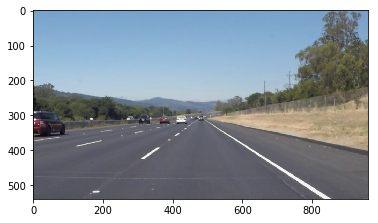

In [8]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

#### IDEAS for lane detection
**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

#### Explain gray scal

In [11]:
## convert to Gray
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
 

#### Explain Canny Filter

In [12]:
## Apply Canny Filter 
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

#### Explain Gaussian blur filter

In [14]:
def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

#### Explain mask

In [16]:
def region_of_interest(img, vertices):

    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

#### Explain draw line
    # The idea of algorithm is
    # 1. classify lines by slope in two listes: right and left. 
    # if slope > 0 it's right side and if slope < 0 it's left side
    # 2. for each line calculate slope and intercept
    # 3. get the average of slope and intercept for right and left
    # 2. looking for x value for extreme points y 
    # 3. concatinate them to get the full two lines
    # 4. Draw extrapolated line

In [24]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=15):

          
    right_line = []
    left_line = []
    
    right_slope = []
    left_slope = []
    
    right_intercept = []
    left_intercept = []

       
    for line in lines:
        for x1,y1,x2,y2 in line:
            current_slope = ((y2-y1)/(x2-x1))
            if (current_slope < 0):
                left_line.append([x1, y1])
                left_line.append([x2, y2])
                left_slope.append(current_slope)
                left_intercept.append(y1 - current_slope * x1)
            if (current_slope > 0):
                right_line.append([x1, y1])
                right_line.append([x2, y2])
                right_slope.append(current_slope)
                right_intercept.append(y1 - current_slope * x1) 

    y_max = img.shape[0]
    y_min = img.shape[0] * 0.6
    
    global_left_slope = np.median(left_slope)
    global_right_slope = np.median(right_slope)
    
    global_left_intercept = np.median(left_intercept)
    global_right_intercept = np.median(right_intercept)
    
    if(global_left_slope != 0):
        left_x_max = (y_max - global_left_intercept ) / global_left_slope
        left_x_min = (y_min - global_left_intercept ) / global_left_slope
        
    if(global_right_slope != 0):
        right_x_max = (y_max - global_right_intercept ) / global_right_slope
        right_x_min = (y_min - global_right_intercept ) / global_right_slope

    if not (math.isnan(left_x_min) or math.isnan(left_x_max)) :
        cv2.line(img, (int(left_x_min), int(y_min)), (int(left_x_max), int(y_max)),color, thickness)
        
    if not (math.isnan(right_x_min) or math.isnan(right_x_max)):
        cv2.line(img, (int(right_x_min), int(y_min)), (int(right_x_max), int(y_max)),color, thickness)


#### Explain hough line

In [25]:
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

#### Explain add to image 

In [26]:
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    return cv2.addWeighted(initial_img, α, img, β, λ)

#### Build pipeline

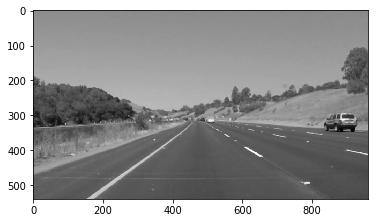

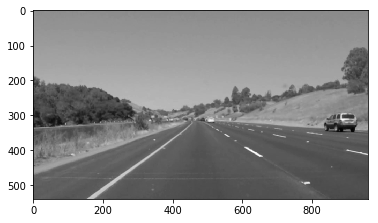

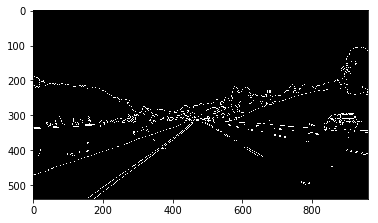

[[[489 313]
  [470 313]
  [  0 540]
  [960 540]]]


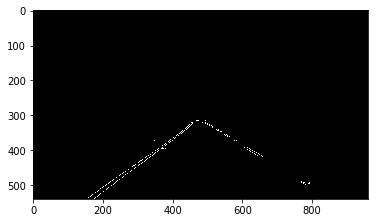

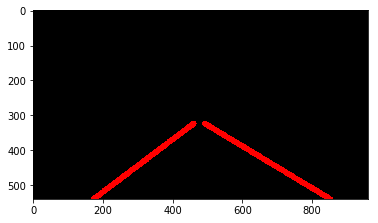

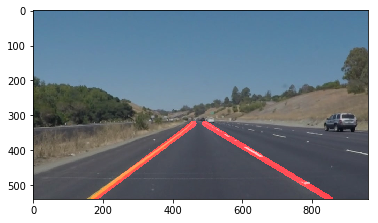

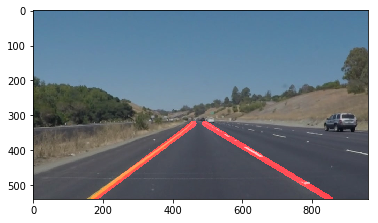

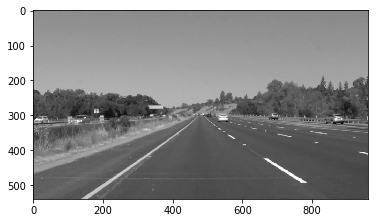

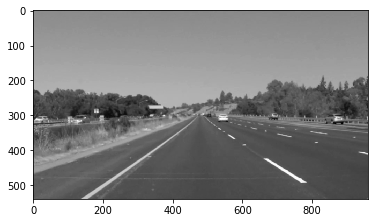

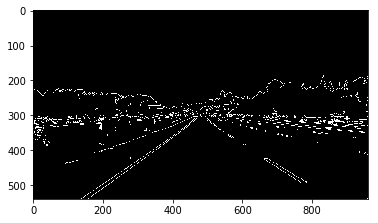

[[[489 313]
  [470 313]
  [  0 540]
  [960 540]]]


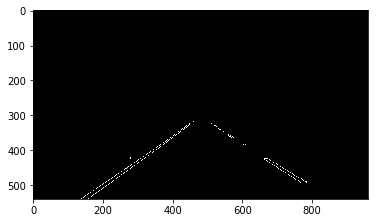

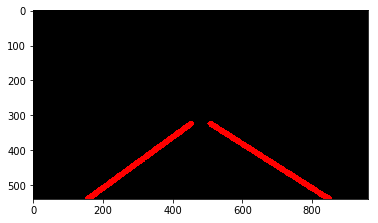

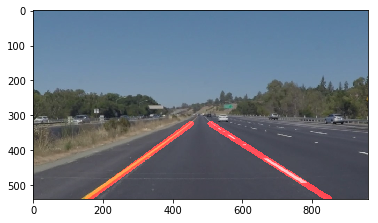

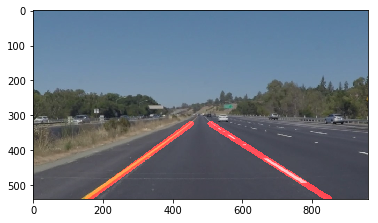

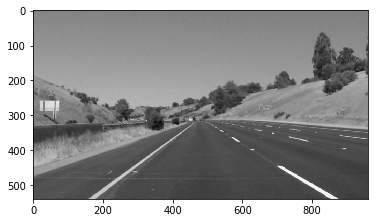

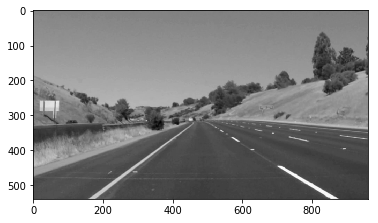

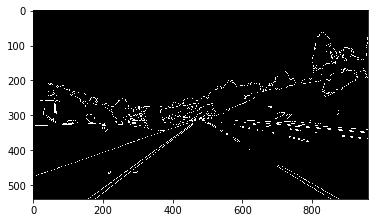

[[[489 313]
  [470 313]
  [  0 540]
  [960 540]]]


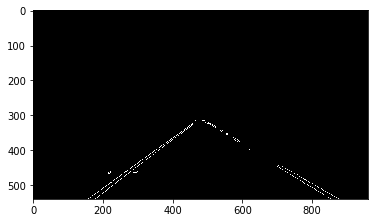

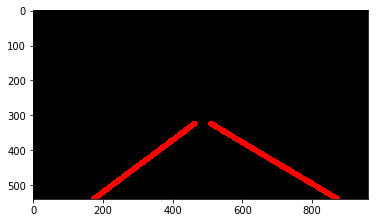

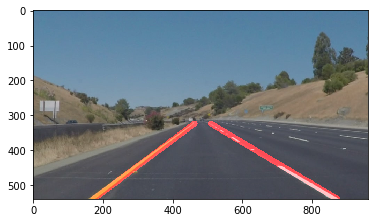

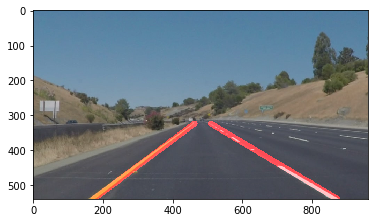

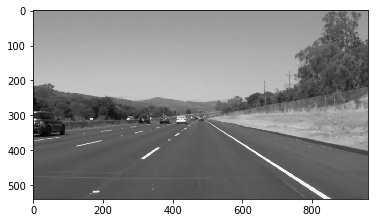

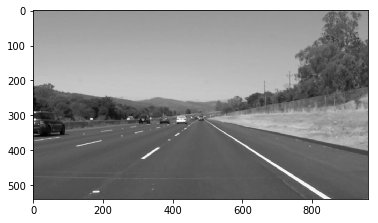

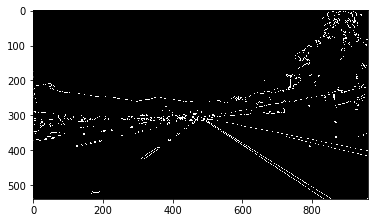

[[[489 313]
  [470 313]
  [  0 540]
  [960 540]]]


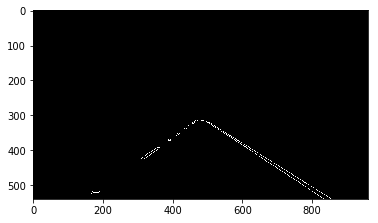

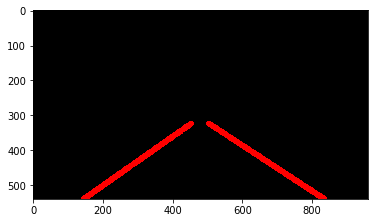

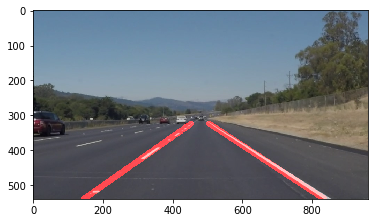

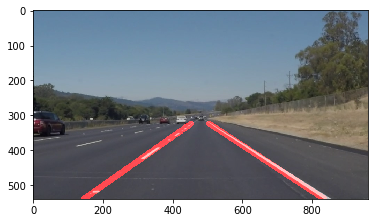

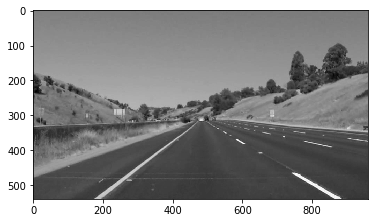

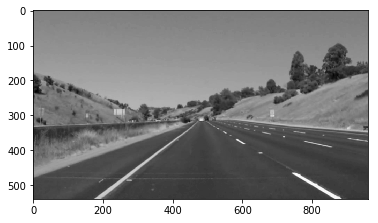

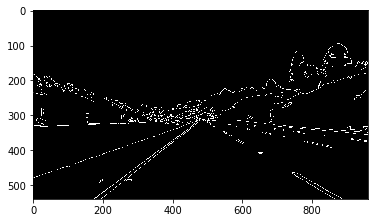

[[[489 313]
  [470 313]
  [  0 540]
  [960 540]]]


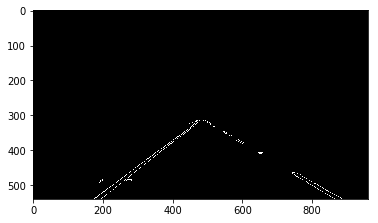

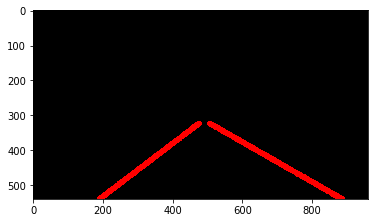

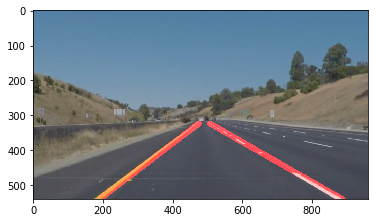

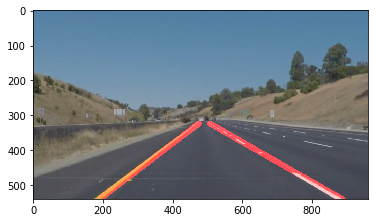

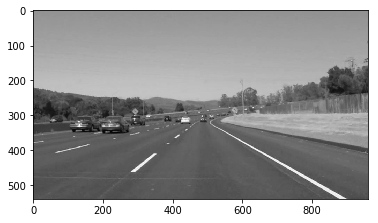

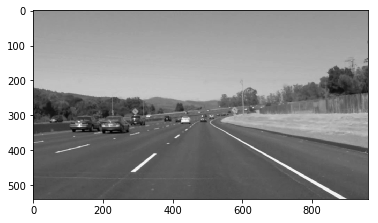

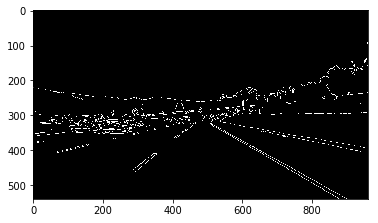

[[[489 313]
  [470 313]
  [  0 540]
  [960 540]]]


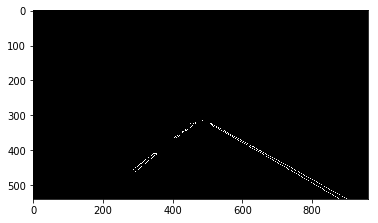

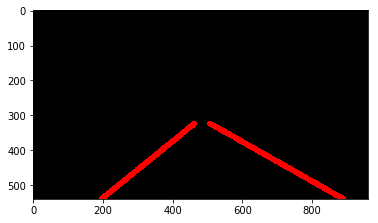

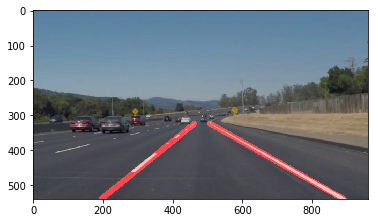

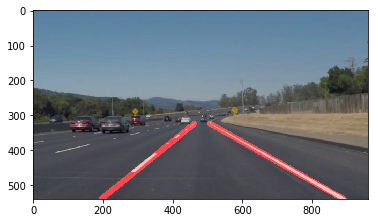

In [27]:
def lane_finding_pipeline(image): 
    gray = grayscale(image)

    plt.imshow(gray,cmap='gray')
    plt.show()
    kernel_size = 3
    blur_gray = gaussian_blur(gray, kernel_size)
    plt.imshow(blur_gray,cmap='gray')
    plt.show()
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)
    plt.imshow(edges,cmap='gray')
    plt.show()
    imshape = image.shape
    vertices = np.array([[(.51*imshape[1],imshape[0]*.58),(.49*imshape[1], imshape[0]*.58), (0, imshape[0]), (imshape[1],imshape[0])]], dtype=np.int32)
    print(vertices)
    masked_image = region_of_interest(edges, vertices)  
    plt.imshow(masked_image,cmap='gray')
    plt.show()
    rho = 1 
    theta = np.pi/180 
    threshold = 35    
    min_line_len = 5
    max_line_gap = 2 
    line_img = hough_lines(masked_image, rho, theta, threshold, min_line_len, max_line_gap)
    plt.imshow(line_img,cmap='gray')
    plt.show()
    weighted = weighted_img(line_img, image)
    plt.imshow(weighted,cmap='gray')
    plt.show()
    return weighted

import os
for element in os.listdir("test_images/"):
    image = cv2.imread("test_images/"+element)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    result = lane_finding_pipeline(image)
    plt.imshow(result,cmap='gray')
    plt.show()


#### import test images

In [21]:

os.listdir("test_images/")

['solidYellowCurve.jpg',
 'solidYellowLeft.jpg',
 'solidYellowCurve2.jpg',
 'solidWhiteRight.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidWhiteCurve.jpg']